In [11]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from collections import OrderedDict

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from torch.autograd import Variable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

import helper

In [12]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

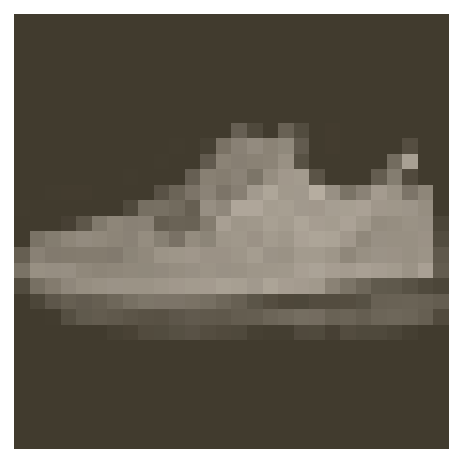

In [13]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

In [14]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [15]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [16]:
epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.605..  Test Loss: 0.534..  Test Accuracy: 0.811
Epoch: 2/30..  Training Loss: 0.482..  Test Loss: 0.517..  Test Accuracy: 0.814
Epoch: 3/30..  Training Loss: 0.449..  Test Loss: 0.499..  Test Accuracy: 0.821
Epoch: 4/30..  Training Loss: 0.432..  Test Loss: 0.477..  Test Accuracy: 0.836
Epoch: 5/30..  Training Loss: 0.421..  Test Loss: 0.469..  Test Accuracy: 0.838
Epoch: 6/30..  Training Loss: 0.420..  Test Loss: 0.458..  Test Accuracy: 0.843
Epoch: 7/30..  Training Loss: 0.406..  Test Loss: 0.455..  Test Accuracy: 0.849
Epoch: 8/30..  Training Loss: 0.392..  Test Loss: 0.433..  Test Accuracy: 0.848
Epoch: 9/30..  Training Loss: 0.395..  Test Loss: 0.458..  Test Accuracy: 0.844
Epoch: 10/30..  Training Loss: 0.388..  Test Loss: 0.447..  Test Accuracy: 0.851
Epoch: 11/30..  Training Loss: 0.386..  Test Loss: 0.466..  Test Accuracy: 0.846
Epoch: 12/30..  Training Loss: 0.380..  Test Loss: 0.455..  Test Accuracy: 0.851
Epoch: 13/30..  Training Loss: 0.376.

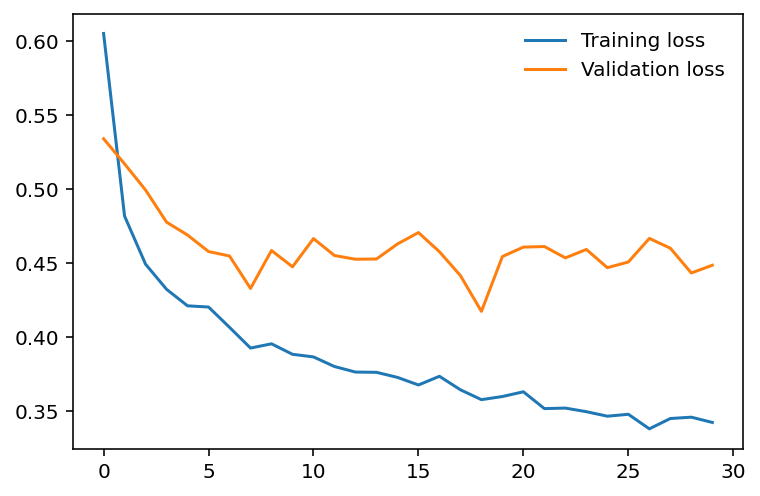

In [17]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

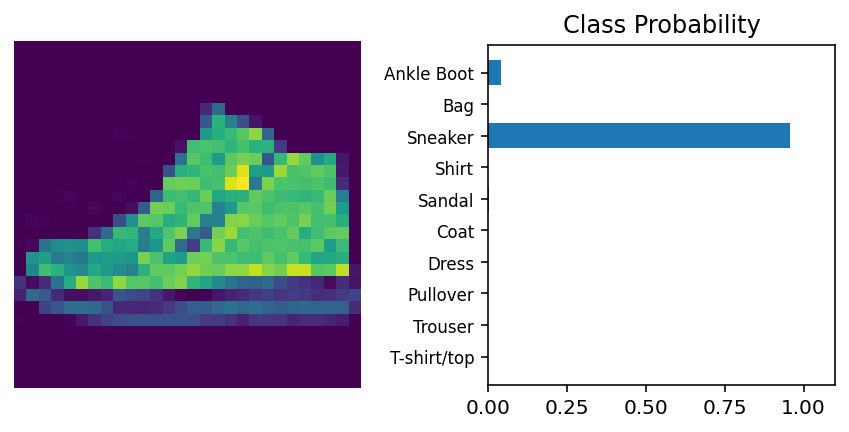

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper

# Test out your network!

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[1]
ps = torch.exp(model(img))

# Plot the image and probabilities
helper.view_classify(img, ps, version='Fashion')